In [648]:
from sympy import *
import numpy as np
import scipy as sp
from scipy.linalg import lu
from scipy.sparse.linalg import spilu
import math
import sympy 
import itertools
import sys
import time
import multiprocessing

from __future__ import print_function


from copy import deepcopy
import time
import fractions
import timeit

import matplotlib.pyplot as plt

%matplotlib inline

%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# print function

In [630]:
def print_row(row,symbols,nvar,precision,cal=False,tol = 10**-5 ):
    # nvar  
    plus_flag = False
    
    for ele in row:
        mul_flag = False
        if ele[0] == 0:
            continue
        constant_flag = True
        for i in range(nvar+1):
            if i==0:
                if plus_flag and ele[i]>0:
                    print('+',end ='')
                if ele[i]==-1.:
                    print('-',end ='')
                    continue
                if ele[i] != 1.:
                    if cal or precision:
                        if cal:
                            mul_flag = True
                        print(ele[i],end="")
                    else:
                        print("%2.2f"%ele[i],end="")
                plus_flag = True
                continue
            if ele[i] != 0:
                if mul_flag:
                    print('*',end = "")
                if cal :
                    mul_flag = True
                print(symbols[i-1],end = "")
                if ele[i] > 1:
                    if cal:
                        print("**",end="")
                    else:
                        print("^",end="")
                    print(int(ele[i]),end="")
                constant_flag = False
        
        if constant_flag and ele[0]==1 :
            if cal or precision:
                print(ele[0],end="")
            else:
                print("%2.2f"%ele[0],end="")
        if constant_flag and ele[0]==-1 :
            if cal or precision:
                print(1,end="")
            else:
                print("%2.2f"%1,end="")
        plus_flag = True
    if cal:
        print(",")
    else:
        print("\\\\")
            
def print_all(M,nvar,symbols=[],cal=False,precision = False):
    if len(symbols) == 0:
        symbols = ['x0','x1','x2','x3','x4','x5','x6','x7'][:nvar]
    for row in M:
        if len(row)!=0:
            print_row(row,symbols,nvar,precision,cal)

## Generate Gauissian Quaduature 

In [632]:
# nomal Gaussian Quaduature
def GQ(n=2):
    result = []
    for i in range(2*n):
        p = []
        for j in range(n):
            p_s = np.zeros(2*n+1,dtype = int)
            p_s[0] = 1
            p_s[2*j+1] = 1
            p_s[2*j+2] = i
            p.append(p_s.tolist())
        if i-i/2*2 == 0:
            p_s = np.zeros(2*n+1)
            p_s[0] = -2./(i+1)
            p.append(p_s.tolist())
        result.append(p)
    return result

def GQ_sym(n=2,Latex = False):        
    result = []
    
    if Latex:
        for i in range(2*n):
            if i-i/2*2 == 0:
                c = "w_%d"%(i/2)
                result.append(c)
            else:
                c = "x_%d"%(i/2)
                result.append(c)
        return result
    
    for i in range(2*n):
        if i-i/2*2 == 0:
            c = "w%d"%(i/2)
            result.append(c)
        else:
            c = "x%d"%(i/2)
            result.append(c)
    return result

In [567]:
def GQS(n=2):
    odd = False
    if n-n/2*2 == 1:
        odd = True
    result = []
    if True:
        for i in range(2*n):
            p = []
            for j in range(n/2):
                p_s = np.zeros(2*n - n/2*2+1,dtype = int)
                p_s[0] = 1
                p_s[2*j+1] = 1
                p_s[2*j+2] = i
                p.append(p_s.tolist())
                
                p_s = np.zeros(2*n - n/2*2+1,dtype = int)
                p_s[0] = 1
                if i-i/2*2 >0:
                    p_s[0] = -1
                p_s[2*j+1] = 1
                p_s[2*j+2] = i
                p.append(p_s.tolist())
            if odd:
                p_s = np.zeros(2*n - n/2*2+1,dtype = int)
                p_s[0] = 1
                p_s[2*n - n/2*2-1] = 1
                p_s[2*n - n/2*2] = i
                p.append(p_s.tolist())
            
            if i-i/2*2 == 0 :
                p_s = np.zeros(2*n - n/2*2+1)
                p_s[0] = -2./(i+1)
                p.append(p_s.tolist())
            
            result.append(p)
        return result
    for i in range(2*n):
        p = []
        for j in range(n/2):
            p_s = np.zeros(2*n+1,dtype = int)
            p_s[0] = 1
            p_s[2*j+1] = 1
            p_s[2*j+2] = i             
            p.append(p_s.tolist())
                
            p_s = np.zeros(2*n+1,dtype = int)
            p_s[0] = 1
            if i-i/2*2 >0:
                p_s[0] = -1
            p_s[2*j+1] = 1
            p_s[2*j+2] = i
            p.append(p_s.tolist())
        if i-i/2*2 == 0:
            p_s = np.zeros(n+1)
            p_s[0] = -2./(i+1)
            p.append(p_s.tolist())
        result.append(p)
    return result

# formation of the coefficient matri for multi-variable

In [568]:
def matC_sparse(polynomials, mdeg,nvar=2):
    row = []
    col =[]
    ele = []
    
    rows = len(polynomials)
    cols = mdeg**nvar
    
    for i in range(rows):
        for monomial in polynomials[i]:
            s = cols-1
            for j in range(nvar):
                s -= monomial[j+1]*mdeg**(nvar-1-j)
            row.append(i)
            col.append(s)
            ele.append(1.0*monomial[0])
    M = sp.sparse.csr_matrix((ele, (row, col)), shape=(rows, cols))
    return M


# Gaussian Elimination

In [569]:
def GEPP_sparse(C):    
    M1 = C.copy()
    M1 = M1.tocsc()
    n = M1.shape[0]  ## number of rows
    m = M1.shape[1]  ## number of columns

    currentrow = 0
    for i in range(m):
        if M1[currentrow:,i].nnz==0:
            pass  ## do nothing if we have a column of zeros
        else:
            if currentrow < (n-1):
                    #print(i)
                    ## first find index of (abs) maximum value
                non_zero_row = M1[currentrow:n,i]
                sub_index = np.argmax(abs(sp.sparse.find(non_zero_row)[2]))
                index = sp.sparse.find(non_zero_row)[0][sub_index]+currentrow  #### n\n-1 
                    #print(M[currentrow:n,i])
                    #print(index)
                    #print("index is", index,"\n")
                # swap rows
                a_idx = np.where(M1.indices == index)
                b_idx = np.where(M1.indices == currentrow)
                M1.indices[a_idx] = currentrow
                M1.indices[b_idx] = index    
                          ####
                #print("the matrix is now \n",M,"\n")
                #print(M)

                    ## running the elimination step
                for j in range(currentrow+1,n):
                    if M1[j,i]!=0:
                            #print("currentrow column entry is", M[currentrow,i],"\n")
                        multiplier = M1[j,i]/M1[currentrow,i]
                            #print("multiplier is", multiplier,"\n")
                        M1[j,i:] = M1[j,i:] - multiplier*M1[currentrow,i:]
                    else:
                        pass
                    #print("the matrix is after elimination \n",M,"\n")

                    ## incrementing row so the algorithm stops when we have a triangular system
    
                currentrow = currentrow + 1
    
    M1=M1.tocsr()
    
    for j in range(n):
        if M1[j,:].nnz==0:
            continue  ## do nothing if we have a row of zeros
        else:
       

            indptr = M1.indptr
            a = indptr[j]
            b = indptr[j+1]
            M1.data[a:b] = M1.data[a:b]/M1.data[a] 
      

    return M1.tocsr()


# Buchberger's algorithm for multi-variable

In [570]:
## sparse

# input the start th leading
def leading_sparse(row,start=0):
    if row.nnz==0:
        return -1
    if start >= row.nnz:
        return -1
        
        print("leading term overflow")
        print(row)
        print(start)
        sys.exit()
    
    return row.indices[start]
    # return sp.sparse.find(row)[1][start]
    

def leading_term_sparse(arg,mdeg,nvar):
    # return leading term without coefficient
    
    result = np.zeros(nvar)
    a = arg
    b = 0
    for i in range(nvar):
        div = mdeg**(nvar-1-i)
        b = a - a/div*div
        a = a/div
        result[i]=mdeg-1-a
        a = b
    return result

def check_multiple_sparse(lead_1,lead_2,nvar):
    # check lead_1 is a multiple of lead_2
    for i in range(nvar):
        if lead_1[i]<lead_2[i]:
            return False
    return True

def shift_col_sparse(lcm,deg_i,mdeg,nvar):
    a = lcm[:-1]-deg_i
    shift_column = 0
    for i in range(nvar):
        shift_column += mdeg**(nvar-1-i)*a[i]
    return int(shift_column)

# input sparse matirx
def shift_sparse(lcm,deg_i,mdeg,nvar,row=-1,leading=-1,S=(-1,-1)):
    row = row.tocsr()
    row_copy = deepcopy(row)
    shift_column = shift_col_sparse(lcm,deg_i,mdeg,nvar)
    if leading-shift_column < 0:
        print(S,leading,shift_column)
        print(row)
        print("degree overflow")
        sys.exit()
    row_copy.indices[:] -= shift_column

    return row_copy

def get_lcm_sparse(a,b): 
    return abs(a * b) / fractions.gcd(a,b) if a and b else 0

def check_multiple_sparse(lead_1,lead_2,nvar):
    # check lead_1 is a multiple of lead_2
    for i in range(nvar):
        if lead_1[i]<lead_2[i]:
            return False
    return True

def remainder_sparse(M,new_row,mdeg, nvar):
    M = M.tocsr()
    flag = True
    m = M.shape[0]
    while flag:
        flag = False
        new_lead = leading_sparse(new_row)
        if new_lead==-1:
            break
        new_lead_term = leading_term_sparse(new_lead,mdeg,nvar)
        for i in range(m):
            row_lead = leading_sparse(M[i])
            row_lead_term = leading_term_sparse(row_lead,mdeg,nvar)
            if check_multiple_sparse(new_lead_term,row_lead_term,nvar):
                #print(i)
                lcm = np.hstack((new_lead_term,[1]))
                old_shifted = shift_col_sparse(lcm,row_lead_term,mdeg,nvar)
                coeff = new_row[0,new_lead]
                
                current_row = deepcopy(M[i])
                #print(current_row)
                current_row.indices[:] -= old_shifted
                #print(current_row)
                
                new_row -= coeff * current_row
                flag = True
                break
    return new_row

def Buchberger_sparse(M, mdeg, nvar, S):
    # check leading term
    a = M[S[0]]
    b = M[S[1]]
    
    arg_a = leading_sparse(a)
    arg_b = leading_sparse(b)
    
    if arg_a==-1 or arg_b==-1:
        return 0,M
        
        print("0 row occur")
        print(S)
        print(M)
        sys.exit()
    
    deg_a = leading_term_sparse(arg_a,mdeg,nvar)
    deg_b = leading_term_sparse(arg_b,mdeg,nvar)
    
    
    lcm = np.zeros(nvar+1)
    for i in range(nvar):
        lcm[i] = max(deg_a[i],deg_b[i])
        
    if(a[0,arg_a]<0):
        a *= -1
        
    if(b[0,arg_b]<0):
        b *= -1

    lcm[nvar] = get_lcm_sparse(a[0,arg_a],b[0,arg_b])
    

    a_shifted = shift_sparse(lcm,deg_a,mdeg,nvar,a,arg_a,S)
    b_shifted = shift_sparse(lcm,deg_b,mdeg,nvar,b,arg_b,S)
    
    """   
    if a[0,arg_a]!=1 or b[0,arg_b]!=1:
        print("Normalization in Gaussian Elimination Failed")
        print(M)
        sys.exit()
    """
    if a[0,arg_a]> b[0,arg_b]:
        new_row = a_shifted - (a[0,arg_a]/ b[0,arg_b])*b_shifted
    else:
        new_row = (b[0,arg_b]/a[0,arg_a])*a_shifted - b_shifted
    
    new_row = remainder_sparse(M,new_row,mdeg, nvar)
    

    if new_row.nnz == 0:
        return 0,M
    
    # normalize new column
    arg_c = leading_sparse(new_row)
    
    if new_row[0,arg_c]!=1:
        new_row.data[:] /= new_row[0,arg_c]
    M = sp.sparse.vstack([M,new_row])
    return 1,M




# Reduced 

In [571]:
def find_largest(lead_v):
    # l is the largest
    l = -1
    arg = -1
    
    m = lead_v.shape[0]
    
    for row in range(m):
        if l == -1:
            l = lead_v[row,-1]
            arg = row
            continue
        if lead_v[row,-1] != -1 and lead_v[row,-1]<l:
            l = lead_v[row,-1]
            arg = row
    if l == -1:
        return -1
    return arg

def renew_lead_v(M,mdeg,nvar,lead_v,row,starts,tol=10**-4):
    m = M.shape[0]
    
    lead_v[row,-1] = leading_sparse(M[row],starts[row])
    while abs(M[row,lead_v[row,-1]]) < tol:
        
        M[row,lead_v[row,-1]]=0
        M.eliminate_zeros()
        lead_v[row,-1] = leading_sparse(M[row],starts[row])

        if lead_v[row,-1] == -1:
            return M,lead_v    
    if lead_v[row,-1] == -1:
        return M,lead_v   
    monomial = leading_term_sparse(lead_v[row,-1],mdeg,nvar)
    for j in range(nvar):
        lead_v[row,j] = monomial[j]
    return M,lead_v
    
def reduced_form(M,mdeg,nvar,tol):
    m,n = M.shape
    
    # the vector store the leading term
    lead_v = np.zeros((m,nvar+1),dtype = int)
    
    # vector stores the i the leading term
    starts = np.zeros(m,dtype = int)
    
    # initialization leading_vector
    for row in range(m):
        M,lead_v = renew_lead_v(M,mdeg,nvar,lead_v,row,starts,tol)
    
    large_row = find_largest(lead_v)
    while large_row != -1:
        flag = False
        for row in range(m):
            if row != large_row and starts[row] == 0:
                lead_arg = leading_sparse(M[row])
                lead_term = leading_term_sparse(lead_arg,mdeg,nvar)
                if check_multiple_sparse(lead_v[large_row,:-1],lead_term,nvar):

                    shift_col = shift_col_sparse(lead_v[large_row],lead_term,mdeg,nvar)
                    indices = deepcopy(M[row].indices) - shift_col
                    indptr = np.zeros(m+1,dtype = int)
                    for i in range(large_row+1,m+1):
                        indptr[i] = indices.shape[0]
                    data = deepcopy(M[row].data)
                    M_subtrac = sp.sparse.csr_matrix((data, indices, indptr), shape=(m, n))
                    c = M[large_row,lead_v[large_row,-1]]/M[row,lead_v[row,-1]]
                    M -= c*M_subtrac
                    flag = True
                    break
        if flag == False:
            starts[large_row]+=1

        M,lead_v=renew_lead_v(M,mdeg,nvar,lead_v,large_row,starts,tol)
        large_row = find_largest(lead_v)
    
    return M
    #print_all(matrix_to_array_sparse(M,mdeg,nvar),['A0','x0','A1','x1'],nvar)

    

# Combine them together

In [641]:
def delete_row_csr(mat, i):
    if not isinstance(mat, sp.sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    n = mat.indptr[i+1] - mat.indptr[i]
    if n > 0:
        mat.data[mat.indptr[i]:-n] = mat.data[mat.indptr[i+1]:]
        mat.data = mat.data[:-n]
        mat.indices[mat.indptr[i]:-n] = mat.indices[mat.indptr[i+1]:]
        mat.indices = mat.indices[:-n]
    mat.indptr[i:-1] = mat.indptr[i+1:]
    mat.indptr[i:] -= n
    mat.indptr = mat.indptr[:-1]
    mat._shape = (mat._shape[0]-1, mat._shape[1])

def trun_zero_sparse(M):
    while M[-1,:].nnz==0:
        M = M[:-1,:]
    return M

def normalize_leading_sparse(M):
    m = M.shape[0]
    for i in range(m):
        lead = leading_sparse(M[i])
        if lead == -1:
            #delete_row_csr(M, i)
            continue
        indptr = M.indptr
        a = indptr[i]
        b = indptr[i+1]
        M.data[a:b] = M.data[a:b]/M.data[a]
    return M

In [573]:
def check_nvar(row):
    ele = 0
    arg = -1
    nvar = row.shape[0]
    for i in range(nvar):
        if row[i] == 1:
            ele += 1
            arg = i
    if ele == 1:
        return arg
    if ele == 0:
        return -2
    return -1

def check_terminate(M,mdeg,nvar):
    M.eliminate_zeros()
    m = M.shape[0]
    
    Var = np.zeros((m,nvar))
    for i in range(m):
        for j in range(M[i].nnz):
            lead = leading_sparse(M[i],j)
            if lead == -1:
                print("check_terminate problem")
                sys.exit()
            term = leading_term_sparse(lead,mdeg,nvar)
            for k in range(nvar):
                if term[k] != 0:
                    Var[i,k] = 1.
    C_E = np.zeros(nvar,dtype = int)
    flag = True
    
    #print(Var)
    while(flag):
        flag = False
        row_num = 0
        while row_num<Var.shape[0]:
            c = check_nvar(Var[row_num])
            #print(row_num,c)
            #print(Var)
            if c > -1:
                C_E[c] = 1
                Var[:,c] = 0
                Var=np.delete(Var, row_num, 0)
                flag = True
                break
            if c == -2:
                Var=np.delete(Var, row_num, 0)
                continue
            row_num += 1
    #print(C_E)
    if sum(C_E) == nvar:
        return True
    return False

In [702]:
def run_sparse(M, mdeg, nvar,tol = 10**-14,details = False,cal = False,Gro = False,Red = True,symbols = []):
    #M = GEPP_sparse(M)
    
    max_row = M.shape[0]-1
    current_row = 0
    flag = -1
    M=reduced_form(M,mdeg,nvar,tol)
    if details:
        print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,symbols,cal)
        print("")
    #M=normalize_leading_sparse(M)
    while current_row != max_row:
        #print(current_row,max_row)
        current_row +=1
        #M = GEPP(M)
        for i in range(current_row):
            M=normalize_leading_sparse(M)
            flag,M = Buchberger_sparse(M, mdeg, nvar, [current_row,i])
            if flag == 1 and Red:
                M=reduced_form(M,mdeg,nvar,tol)
                if details:
                    print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,symbols,cal)
                    print("")
                if Gro == False:
                    if check_terminate(M,mdeg,nvar):
                        M=normalize_leading_sparse(M)
                        return M
        #time.sleep(1)
        #M = GEPP(M)
        #M = trun_zero(M)
        M=normalize_leading_sparse(M)
        #print(M)
        max_row = M.shape[0]-1
    M=normalize_leading_sparse(M)
    return M


# Testing

Here we test $p_1=x^2$ and $p_2=xy+y^2$. And get Grobner basis $g_1=x^2, g_2=xy+y^2, g_3 = y^3$.

In [575]:
p1 = [(1,2,0)]
p2 = [(1,1,1),(1,0,2)]
polynomials = [p1,p2]
mdeg = 5
nvar = 2
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar,Gro=True,Red=False)
#M.toarray()
print_all(matrix_to_array_sparse(M,mdeg,nvar),2,['x','y']) 


x^2\\
xy+y^2\\
y^3\\


In [576]:
%%timeit
p1 = [(1,2,0)]
p2 = [(1,1,1),(1,0,2)]
polynomials = [p1,p2]
mdeg = 5
nvar = 2
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar,Gro=True)
#M.toarray()



100 loops, best of 3: 8.24 ms per loop


Here we test $p_1=xyz+xy$ and $p_2=x^2y^2z+yz$. And get Grobner basis $g_1=x^2y^2z+yz, g_2=xyz+xy, g_3=x^2y^2-2yz, g_4 = yz^2+yz$.

In [577]:
p1 = [(1,1,1,1),(1,1,1,0)]
p2 = [(2,0,1,1),(1,2,2,1)]
polynomials = [p1,p2]
mdeg = 5
nvar = 3
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar,Gro=True,Red=False)
#M.toarray()
print_all(matrix_to_array_sparse(M,mdeg,nvar),3,['x','y','z']) 


xyz+xy\\
x^2y^2-2.00yz\\
yz^2+yz\\


# Solving Gaussian Quadrature for $n=2$

In [578]:
p1= [(1,1,0,0,0),(1,0,0,1,0),(-2,0,0,0,0)]
p2= [(1,1,1,0,0),(1,0,0,1,1)]
p3= [(1,1,2,0,0),(1,0,0,1,2),(-2.0/3,0,0,0,0)]
p4= [(1,1,3,0,0),(1,0,0,1,3)]
polynomials = [p1,p2,p3,p4]
mdeg = 10
nvar = 4
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar)
#M.toarray()
#print_array_sparse(matrix_to_array_sparse(M,mdeg,nvar)) 
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,['A0','x0','A1','x1'])

A0-1.00\\
-x1^2+0.33\\
-0.33x0-0.33x1\\
0.33A1+x1^2-0.67\\


In [579]:
%memit matC_sparse(polynomials,mdeg,nvar)


peak memory: 56.12 MiB, increment: 0.00 MiB


In [580]:
M = matC_sparse(polynomials,mdeg,nvar)

def T(M,mdeg,nvar,loop=50):
    for i in range(loop):
        M = matC_sparse(polynomials,mdeg,nvar)
        run_sparse(M, mdeg,nvar)
%memit run_sparse(M, mdeg,nvar)


peak memory: 56.14 MiB, increment: 0.00 MiB


In [581]:
M = matC_sparse(polynomials,mdeg,nvar)
%timeit run_sparse(M, mdeg,nvar) 


10 loops, best of 3: 26.2 ms per loop


# Symmetric Gaussian Quadrature

## n = 3

In [633]:
n = 3
polynomials = GQS(n)
#print_array_sparse(polynomials)
mdeg = 20
nvar = 2*n-n/2*2
M=matC_sparse(polynomials,mdeg,nvar)
#print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,GQ_sym(n),cal = True)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = True,cal=True,Gro=True,symbols=GQ_sym(n))
#M.toarray()
#print_array_sparse(matrix_to_array_sparse(M,mdeg,nvar)) 

print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,GQ_sym(n,True),cal = False,precision = True)

2.0*w0-1.11111111111,
0.888888888889*x1,
-0.6*w1+0.533333333333,
0.666666666667*x0**2-0.4,

w_0-0.555555555556\\
x_1\\
w_1-0.888888888889\\
x_0^2-0.6\\


In [583]:
%%timeit
n = 3
polynomials = GQS(n)
#print_array_sparse(polynomials)
mdeg = 20
nvar = 2*n-n/2*2
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)
#M.toarray()

10 loops, best of 3: 34.1 ms per loop


In [584]:
%%memit
n = 3
polynomials = GQS(n)
#print_array_sparse(polynomials)
mdeg = 20
nvar = 2*n-n/2*2
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)

peak memory: 56.15 MiB, increment: 0.00 MiB


## n = 4

In [645]:
n = 4
polynomials = GQS(n)
#print_array_sparse(polynomials)
mdeg = 20
nvar = 2*n-n/2*2
M=matC_sparse(polynomials,mdeg,nvar)
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,GQ_sym(n,Latex=True),cal = False, precision = True)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = True,cal=True,symbols=GQ_sym(n))
#M.toarray()
#print_array_sparse(matrix_to_array_sparse(M,mdeg,nvar)) 

#print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,GQ_sym(n),cal = True)
M = normalize_leading_sparse(M)
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,GQ_sym(n,Latex=True),cal = False,precision= True)

2.0w_0+2.0w_1-2.0\\
\\
2.0w_0x_0^2+2.0w_1x_1^2-0.666666666667\\
\\
2.0w_0x_0^4+2.0w_1x_1^4-0.4\\
\\
2.0w_0x_0^6+2.0w_1x_1^6-0.285714285714\\
\\
2.0*w0+2.0*w1-2.0,
-2.0*x0**2*w1+2.0*x0**2+2.0*w1*x1**2-0.666666666667,
-2.0*x0**2*x1**2+0.666666666667*x0**2+0.666666666667*x1**2-0.4,
-2.0*x0**4*x1**2+0.666666666667*x0**4+0.4*x1**2-0.285714285714,

w0+w1-1,
x0**2*w1+0.6*w1+x1**2-0.990476190476,
-0.444444444444*x1**4+0.380952380952*x1**2-0.0380952380952,
-0.2*x0**2-0.333333333333*x1**4+0.0857142857143*x1**2+0.142857142857,
0.190476190476*w1*x1**2+0.114285714286*w1-0.0888888888889,

w_0+w_1-1\\
x_0^2w_1+0.6w_1+x_1^2-0.990476190476\\
x_1^4-0.857142857143x_1^2+0.0857142857143\\
x_0^2+1.66666666667x_1^4-0.428571428571x_1^2-0.714285714286\\
w_1x_1^2+0.6w_1-0.466666666667\\


In [586]:
%%timeit
n = 4
polynomials = GQS(n)
#print_array_sparse(polynomials)
mdeg = 20
nvar = 2*n-n/2*2
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)

10 loops, best of 3: 49.4 ms per loop


In [587]:
%%memit
n = 4
polynomials = GQS(n)
#print_array_sparse(polynomials)
mdeg = 20
nvar = 2*n-n/2*2
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)

peak memory: 56.15 MiB, increment: 0.00 MiB


In [588]:
A0=0.6521451548625461
x0=-0.3399810435848563
A1=0.3478548451374538
x1=0.8611363115940526
print(A0+A1-1.0,
x0**2.0*A1+0.6*A1+x1**2.0-0.990476190476,
-0.444444444444*x1**4.0+0.380952380952*x1**2.0-0.0380952380952,
-0.2*x0**2.0-0.333333333333*x1**4.0+0.0857142857143*x1**2.0+0.142857142857,
0.190476190476*A1*x1**2.0+0.114285714286*A1-0.0888888888889)

-1.11022302463e-16 1.90403248723e-13 -6.93889390391e-18 5.10425035571e-14 3.91214838302e-14


# n = 5

In [642]:
n = 5
polynomials = GQS(n)
#print_array_sparse(polynomials)
mdeg = 20
nvar = 2*n-n/2*2
M=matC_sparse(polynomials,mdeg,nvar)
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,GQ_sym(n,Latex=True),cal = False, precision = True)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = True,cal=True,symbols=GQ_sym(n))
#M.toarray()
#print_array_sparse(matrix_to_array_sparse(M,mdeg,nvar)) 
#print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,GQ_sym(n),cal = True)
M = normalize_leading_sparse(M)
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,GQ_sym(n,Latex=True),cal = False,precision= True)

2.0w_0+2.0w_1+w_2-2.0\\
w_2x_2\\
2.0w_0x_0^2+2.0w_1x_1^2+w_2x_2^2-0.666666666667\\
w_2x_2^3\\
2.0w_0x_0^4+2.0w_1x_1^4+w_2x_2^4-0.4\\
w_2x_2^5\\
2.0w_0x_0^6+2.0w_1x_1^6+w_2x_2^6-0.285714285714\\
w_2x_2^7\\
2.0w_0x_0^8+2.0w_1x_1^8+w_2x_2^8-0.222222222222\\
w_2x_2^9\\
2.0*w0+2.0*w1+w2-2.0,
w2*x2,
-2.0*x0**2*w1-x0**2*w2+2.0*x0**2+2.0*w1*x1**2-0.666666666667,
x0**2*x1**2*w2-2.0*x0**2*x1**2+0.666666666667*x0**2+0.666666666667*x1**2-0.4,
x0**4*x1**2*w2-2.0*x0**4*x1**2+0.666666666667*x0**4+0.4*x1**2-0.285714285714,
x0**6*x1**2*w2-2.0*x0**6*x1**2+0.666666666667*x0**6+0.285714285714*x1**2-0.222222222222,

w0+w1-0.715555555556,
0.568888888889*x2,
x0**2*w1+0.230769230769*w1+0.715555555556*x1**2-0.710959164292,
0.238095238095*w2-0.13544973545,
0.106666666667*x1**4-0.118518518519*x1**2+0.0253968253968,
0.285714285714*x0**2+0.4*x1**4-0.15873015873*x1**2-0.222222222222,
-0.256790123457*w1*x1**2-0.0592592592593*w1-0.2*w2+0.177777777778,

w_0+w_1-0.715555555556\\
x_2\\
x_0^2w_1+0.230769230769w_1+0.71555

In [590]:
%%timeit
n = 5
polynomials = GQS(n)
#print_array_sparse(polynomials)
mdeg = 20
nvar = 2*n-n/2*2
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)

10 loops, best of 3: 101 ms per loop


In [591]:
%%memit
n = 5
polynomials = GQS(n)
#print_array_sparse(polynomials)
mdeg = 20
nvar = 2*n-n/2*2
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)

peak memory: 56.15 MiB, increment: 0.00 MiB


In [592]:
A2=0.5688888888888889
x2=0.0000000000000000
A1=0.4786286704993665
x1=-0.5384693101056831
A0=0.2369268850561891
x0=-0.9061798459386640
print(A0+A1-0.715555555556,
0.568888888889*x2,
x0**2.0*A1+0.230769230769*A1+0.715555555556*x1**2.0-0.710959164292,
0.238095238095*A2-0.13544973545,
0.106666666667*x1**4.0-0.118518518519*x1**2.0+0.0253968253968,
0.285714285714*x0**2.0+0.4*x1**4.0-0.15873015873*x1**2.0-0.222222222222,
-0.256790123457*A1*x1**2.0-0.0592592592593*A1-0.2*A2+0.177777777778)

-4.44422276757e-13 0.0 5.16031661846e-13 -4.00013355772e-13 -1.3697723511e-13 3.35842464949e-14 1.735833699e-13


In [660]:
%%timeit
n = 1
polynomials = GQS(n)
#print_array_sparse(polynomials)
mdeg = 20
nvar = 2*n-n/2*2
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)

100 loops, best of 3: 3.8 ms per loop


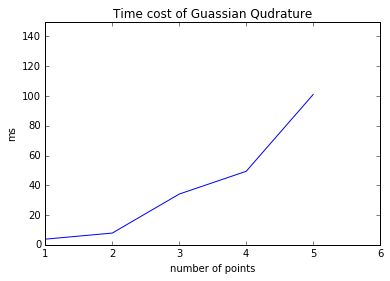

In [700]:
plt.ylabel('ms')
plt.xlabel('number of points')
plt.title('Time cost of Guassian Qudrature')
plt.axis([1, 6,0,150])
plt.plot([1,2,3,4,5],[3.8,7.88,34.1,49.4,101])

# Solving Gaussian Quadrature without symmetry

## n = 3

In [593]:
n = 3
polynomials = GQ(n)
mdeg = 20
nvar = n*2
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)
#M.toarray()
#print_array_sparse(matrix_to_array_sparse(M,mdeg,nvar)) 
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,GQ_sym(n),cal = True)


w0+w1-0.555555555556*x2**2-1.11111111111,
0.45*w1*x2+0.9*x1*w2+0.25*x1*x2**2-0.8*x1-0.4*x2,
x2**3-0.6*x2,
-x1**2-1.0*x1*x2-1.0*x2**2+0.6,
x0+x1+1.66666666667*x2**3,
0.675*w1*w2-1.26666666667*w1-2.0*x1**2+0.75*x1*w2**2*x2-4.25*x1*w2*x2+0.625*x1*x2+0.675*w2**2-0.75462962963*x2**2+1.03703703704,
0.666666666667*w1*x1+0.333333333333*w1*x2+0.708333333333*x1*w2+0.208333333333*x1*x2**2-1.0*x1-0.37037037037*x2**3-0.0740740740741*x2,
-0.6*w2-0.333333333333*x2**2+0.533333333333,


In [594]:
A0=0.8888888888888888
x0=0.0000000000000000
A1=0.5555555555555556
x1=-0.7745966692414834
A2=0.5555555555555556
x2=0.7745966692414834

print(A0+A1-0.555555555556*x2**2.0-1.11111111111,
0.45*A1*x2+0.9*x1*A2+0.25*x1*x2**2.0-0.8*x1-0.4*x2,
x2**3.0-0.6*x2,
-1.0*x1**2.0-1.0*x1*x2-1.0*x2**2.0+0.6,
x0+x1+1.66666666667*x2**3.0,
0.675*A1*A2-1.26666666667*A1-2.0*x1**2.0+0.75*x1*A2**2.0*x2-4.25*x1*A2*x2+0.625*x1*x2+0.675*A2**2.0-0.75462962963*x2**2.0+1.03703703704,
0.666666666667*A1*x1+0.333333333333*A1*x2+0.708333333333*x1*A2+0.208333333333*x1*x2**2.0-1.0*x1-0.37037037037*x2**3.0-0.0740740740741*x2,
-0.6*A2-0.333333333333*x2**2.0+0.533333333333)

8.44213587925e-13 0.0 5.55111512313e-17 -1.11022302463e-16 1.54920520856e-12 8.88844553515e-13 1.63570545997e-13 -1.33337785257e-13


In [595]:
%%memit
n = 3
polynomials = GQ(n)
mdeg = 20
nvar = n*2
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)

peak memory: 56.16 MiB, increment: 0.00 MiB


In [596]:
%%timeit
n = 3
polynomials = GQ(n)
mdeg = 20
nvar = n*2
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)

10 loops, best of 3: 170 ms per loop


# Random polynomial

In [597]:
def ran(bound):
    a = int(np.random.random()*bound)
    return a

def Random_P(nvar = 2,ma = 2, m = 2, n =2 , coe = 4):
    Polys = []
    for i in range(m):
        poly = []
        for j in range(n):
            term = []
            term.append(1.*ran(coe)+1)
            for k in range(nvar):
                term.append(1.*ran(ma))
            poly.append(term)
        Polys.append(poly)
    return Polys
            

In [598]:
n = 3
ma = 3
nvar = 3
m=3
mdeg = 100
coe = 4
polynomials = Random_P(nvar,ma, m , n  , coe)
M=matC_sparse(polynomials,mdeg,nvar)
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar)

x0^2x1x2^2+3.00x0x1x2+2.00x1^2x2^2\\
2.00x0^2x1x2^2+2.00x0x2^2+2.00x1\\
2.00x0^2x1+3.00x0x2+3.00x1x2^2\\


In [599]:
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)
#M.toarray()
#print_array_sparse(matrix_to_array_sparse(M,mdeg,nvar)) 
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar)

x0x2^2\\
x0^2x1+1.50x0x2\\
x0x1x2-3.00x0x2^2\\
x0x1^2\\
0.07x1\\
-37865216117247534562030095341800318153193947136.00x1^3+1.04x1\\
2173517.69x1^2\\


In [600]:
n = 3
ma = 3
nvar = 3
m=3
mdeg = 100
coe = 4
polynomials = Random_P(nvar,ma, m , n  , 1)
print(polynomials)
M=matC_sparse(polynomials,mdeg,nvar)
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,['x','y','z'])
#print(M)
print("")
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)
#M.toarray()
#print_array_sparse(matrix_to_array_sparse(M,mdeg,nvar)) 
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,['x','y','z'],cal =True)

[[[1.0, 0.0, 2.0, 1.0], [1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 1.0, 1.0]], [[1.0, 1.0, 2.0, 0.0], [1.0, 2.0, 1.0, 2.0], [1.0, 2.0, 1.0, 2.0]], [[1.0, 2.0, 1.0, 1.0], [1.0, 0.0, 0.0, 1.0], [1.0, 1.0, 0.0, 0.0]]]
y^2z+yz+1.00\\
2.00x^2yz^2+xy^2\\
x^2yz+x+z\\

16.0*z**11+8.0*z**8-4.0*z**7+12.0*z**6+4.0*z**4-2.0*z**3+4.0*z**2+1.0,
0.5*x**2+3.47826086956*z**11-15.652173913*z**10+2.4347826087*z**9+6.78260869565*z**8-9.39130434783*z**7+6.86956521739*z**6-9.91304347826*z**5+0.478260869565*z**4-1.08695652174*z**3+3.26086956522*z**2-3.67391304348*z,
x+25.7391304348*z**11-11.8260869565*z**10-2.78260869565*z**9+17.3913043478*z**8-12.6956521739*z**7+18.4347826087*z**6-6.95652173913*z**5+3.73913043478*z**4-3.04347826087*z**3+7.13043478261*z**2-2.08695652174*z,
-y*z+9.04347826087*z**11-0.695652173913*z**10-4.86956521739*z**9+2.4347826087*z**8-1.21739130435*z**7+6.26086956522*z**6-0.173913043478*z**5+1.04347826087*z**4-1.82608695652*z**3+1.47826086957*z**2+0.347826086957*z,
-0.25*y**2*z+1.73913043478*z**11+

In [601]:
polynomials =[[[1.0, 2.0, 2.0, 2.0], [1.0, 0.0, 1.0, 2.0], [1.0, 2.0, 2.0, 1.0]], [[1.0, 1.0, 2.0, 0.0], [1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 1.0, 0.0]], [[1.0, 1.0, 0.0, 0.0], [1.0, 1.0, 2.0, 0.0], [1.0, 2.0, 2.0, 0.0]]]
n = 3
ma = 3
nvar = 3
m=3
mdeg = 100
coe = 4
M=matC_sparse(polynomials,mdeg,nvar)
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,['x','y','z'],cal = False)
#print(M)
print("")
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=False)
#M.toarray()
#print_array_sparse(matrix_to_array_sparse(M,mdeg,nvar)) 
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,['x','y','z'],cal =False)

x^2y^2z^2+x^2y^2z+yz^2\\
xy^2+y+1.00\\
x^2y^2+xy^2+x\\

xz^2+xz+yz+2.00z^2+z\\
y^2-1.00\\
xy+y^2+y\\
yz^2+yz+1.50z^2+z\\


In [602]:
polynomials = [[[1.0, 2.0, 0.0, 1.0], [1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.0]],
               [[1.0, 2.0, 1.0, 0.0], [1.0, 1.0, 1.0, 0.0], [1.0, 2.0, 2.0, 2.0]], 
               [[1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.0, 2.0], [1.0, 0.0, 0.0, 1.0]]
              ,[[1.0,0,0.,1.],[-1.,.0,.0,0]]]


In [603]:
n = 3
ma = 3
nvar = 3
m=3
mdeg = 100
coe = 4
M=matC_sparse(polynomials,mdeg,nvar)
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,['x','y','z'],cal = False)
#print(M)
print("")
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True,Gro=False,symbols = ['x','y','z'])
#M.toarray()
#print_array_sparse(matrix_to_array_sparse(M,mdeg,nvar)) 
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,['x','y','z'],cal =False)
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,['x','y','z'],cal =True)


x^2z+xyz+xy\\
x^2y^2z^2+x^2y+xy\\
xyz+xz^2+z\\
z-1.00\\

-2.00y^2-2.00y+1.00\\
z-1.00\\
x-2.00y^2+1.00\\
-2.0*y**2-2.0*y+1.0,
z-1,
x-2.0*y**2+1.0,


In [604]:
z = 1.
y = -.5+.5*np.sqrt(3)
x = 2.*y**2-1


In [605]:
print(x**2.0*z+x*y*z+x*y,
x**2.0*y**2.0*z**2.0+x**2.0*y+x*y,
x*y*z+x*z**2.0+z,
z-1.0)

2.22044604925e-16 1.11022302463e-16 0.0 0.0


In [606]:
z = 1.
y = -.5-.5*np.sqrt(3)
x = 2.*y**2-1


In [607]:
print(x**2.0*z+x*y*z+x*y,
x**2.0*y**2.0*z**2.0+x**2.0*y+x*y,
x*y*z+x*z**2.0+z,
z-1.0)


0.0 -4.4408920985e-16 0.0 0.0


In [608]:
z = 0.
y = 10.
x = 0
print(x**2.0*z+x*y*z+x*y,
x**2.0*y**2.0*z**2.0+x**2.0*y+x*y,
x*y*z+x*z**2.0+z)

0.0 0.0 0.0


# Constant Weight

In [609]:
def CWS(n=2):
    odd = False
    if n-n/2*2 == 1:
        odd = True
    result = []
    w = 2./n
    
    if True:
        for i in range(n+1):
            p = []
            if i == 0:
                continue
            for j in range(n/2):
                p_s = np.zeros(n/2+n - n/2*2+1)
                p_s[0] = w
                p_s[j+1] = i
                p.append(p_s.tolist())
                
                p_s = np.zeros(n/2+n - n/2*2+1)
                p_s[0] = w
                if i-i/2*2 >0:
                    p_s[0] = -w
                p_s[j+1] = i
                p.append(p_s.tolist())
            if odd:
                p_s = np.zeros(n/2+n - n/2*2+1)
                p_s[0] = w
                p_s[n/2+n - n/2*2] = i
                p.append(p_s.tolist())
            
            if i-i/2*2 == 0 :
                p_s = np.zeros(n/2+n - n/2*2+1)
                p_s[0] = -2./(i+1)
                p.append(p_s.tolist())
            
            result.append(p)
        return result


## n = 1

In [696]:
%%timeit
n = 1
polynomials = CWS(n)
#print_array_sparse(polynomials)
mdeg = 20
nvar = n/2+n-n/2*2
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)
#M.toarray()

1000 loops, best of 3: 853 µs per loop


## n = 2

In [685]:
n = 2
polynomials = CWS(n)
#print_array_sparse(polynomials)
mdeg = 20
nvar = n/2+n-n/2*2
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)
#M.toarray()
#print_array_sparse(matrix_to_array_sparse(M,mdeg,nvar)) 
#print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,cal = True)
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,['x_0'],cal = False, precision = True)

x_0^2-0.333333333333\\


In [691]:
%%timeit
n = 2
polynomials = CWS(n)
#print_array_sparse(polynomials)
mdeg = 20
nvar = n/2+n-n/2*2
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)
#M.toarray()
#print_array_sparse(matrix_to_array_sparse(M,mdeg,nvar)) 
#print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,cal = True)
#print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,['x_0'],cal = False, precision = True)

1000 loops, best of 3: 1.54 ms per loop


## n = 3

In [688]:
n = 3
polynomials = CWS(n)
#print_array_sparse(polynomials)
mdeg = 20
nvar = n/2+n-n/2*2
M=matC_sparse(polynomials,mdeg,nvar)
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,['x_0','x_1'],cal = False, precision = True)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)
#M.toarray()
#print_array_sparse(matrix_to_array_sparse(M,mdeg,nvar)) 
#print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,cal = True)
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,['x_0','x_1'],cal = False, precision = True)

0.666666666667x_1\\
1.33333333333x_0^2+0.666666666667x_1^2-0.666666666667\\
0.666666666667x_1^3\\
x_1\\
x_0^2-0.5\\


In [692]:
%%timeit
n = 3
polynomials = CWS(n)
#print_array_sparse(polynomials)
mdeg = 20
nvar = n/2+n-n/2*2
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)
#M.toarray()

100 loops, best of 3: 5.98 ms per loop


## n = 4

In [690]:
n = 4
polynomials = CWS(n)
#print_array_sparse(polynomials)
mdeg = 20
nvar = n/2+n-n/2*2
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,['x_0','x_1'],cal = False, precision = True)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)
#M.toarray()
#print_array_sparse(matrix_to_array_sparse(M,mdeg,nvar)) 
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,cal = True)
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,['x_0','x_1'],cal = False, precision = True)

\\
x_0^2+x_1^2-0.666666666667\\
\\
x_0^4+x_1^4-0.4\\
x1**4-0.666666666667*x1**2+0.0222222222222,
x0**2+3.0*x1**4-x1**2-0.6,
x_1^4-0.666666666667x_1^2+0.0222222222222\\
x_0^2+3.0x_1^4-x_1^2-0.6\\


In [694]:
%%timeit
n = 4
polynomials = CWS(n)
#print_array_sparse(polynomials)
mdeg = 20
nvar = n/2+n-n/2*2
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)
#M.toarray()

100 loops, best of 3: 12.1 ms per loop


In [683]:
de = (2./3)**2-4.*2/90
de = np.sqrt(de)
a1 = (2./3+de)/2
a2 = (2./3-de)/2
a1 = np.sqrt(a1)
a2 = np.sqrt(a2)
print(a1,a2)

def fff(aa):
    return 3.0*aa**4-aa**2
c = np.sqrt(.6-fff(a1))
print(c)

0.794654472292 0.187592474085
0.187592474085


## n = 5

In [668]:
n = 5
polynomials = CWS(n)
#print_array_sparse(polynomials)
mdeg = 20
nvar = n/2+n-n/2*2
M=matC_sparse(polynomials,mdeg,nvar)
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,cal = True)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)
#M.toarray()
#print_array_sparse(matrix_to_array_sparse(M,mdeg,nvar)) 
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,cal = True)

0.4*x2,
0.8*x0**2+0.8*x1**2+0.4*x2**2-0.666666666667,
0.4*x2**3,
0.8*x0**4+0.8*x1**4+0.4*x2**4-0.4,
0.4*x2**5,
x2,
x1**4-0.833333333333*x1**2+0.0972222222222,
x0**2+2.4*x1**4-x1**2-0.6,


In [695]:
%%timeit
n = 5
polynomials = CWS(n)
#print_array_sparse(polynomials)
mdeg = 20
nvar = n/2+n-n/2*2
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = False,cal=True)
#M.toarray()

10 loops, best of 3: 27.6 ms per loop


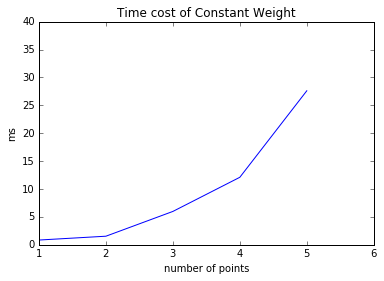

In [701]:
plt.ylabel('ms')
plt.xlabel('number of points')
plt.title('Time cost of Constant Weight')
plt.axis([1, 6,0,40])
plt.plot([1,2,3,4,5],[0.853,1.54,5.98,12.1,27.6])

In [664]:
n = 6
polynomials = CWS(n)
#print_array_sparse(polynomials)
mdeg = 20
nvar = n/2+n-n/2*2
M=matC_sparse(polynomials,mdeg,nvar)
#print(M)
M = run_sparse(M, mdeg,nvar,tol=10**-5,details = True,cal=True)
#M.toarray()
#print_array_sparse(matrix_to_array_sparse(M,mdeg,nvar)) 
print_all(matrix_to_array_sparse(M,mdeg,nvar),nvar,cal = True)

4.0*w1**6-4.0*w1**4+0.8*w1**2-0.0380952380952,
-0.666666666667*x0**4-0.666666666667*x0**2*w1**2+0.666666666667*x0**2-2.0*w1**6+1.33333333333*w1**4+0.266666666667*w1**2-0.114285714286,
0.666666666667*w0**2+2.0*x0**4+2.0*x0**2*w1**2-1.33333333333*x0**2+2.0*w1**6-0.933333333333*w1**2-0.285714285714,

w1**6-1.0*w1**4+0.2*w1**2-0.00952380952381,
x0**4+1.0*x0**2*w1**2-1.0*x0**2+3.0*w1**6-2.0*w1**4-0.4*w1**2+0.171428571429,
w0**2+3.0*x0**4+3.0*x0**2*w1**2-2.0*x0**2+3.0*w1**6-1.4*w1**2-0.428571428571,
x0**2*w1**4-0.125*x0**2*w1**2+0.0078125*x0**2-7.72045650406e+14*w1**6+7.72045650406e+14*w1**4-1.54409130081e+14*w1**2+7.35281571816e+12,

x2**6-1.0*x2**4+0.2*x2**2-0.00952380952381,
x1**4+1.0*x1**2*x2**2-1.0*x1**2+3.0*x2**6-2.0*x2**4-0.4*x2**2+0.171428571429,
x0**2+3.0*x1**4+3.0*x1**2*x2**2-2.0*x1**2+3.0*x2**6-1.4*x2**2-0.428571428571,
x1**2*x2**4-0.125*x1**2*x2**2+0.0078125*x1**2-7.72045650406e+14*x2**6+7.72045650406e+14*x2**4-1.54409130081e+14*x2**2+7.35281571816e+12,
